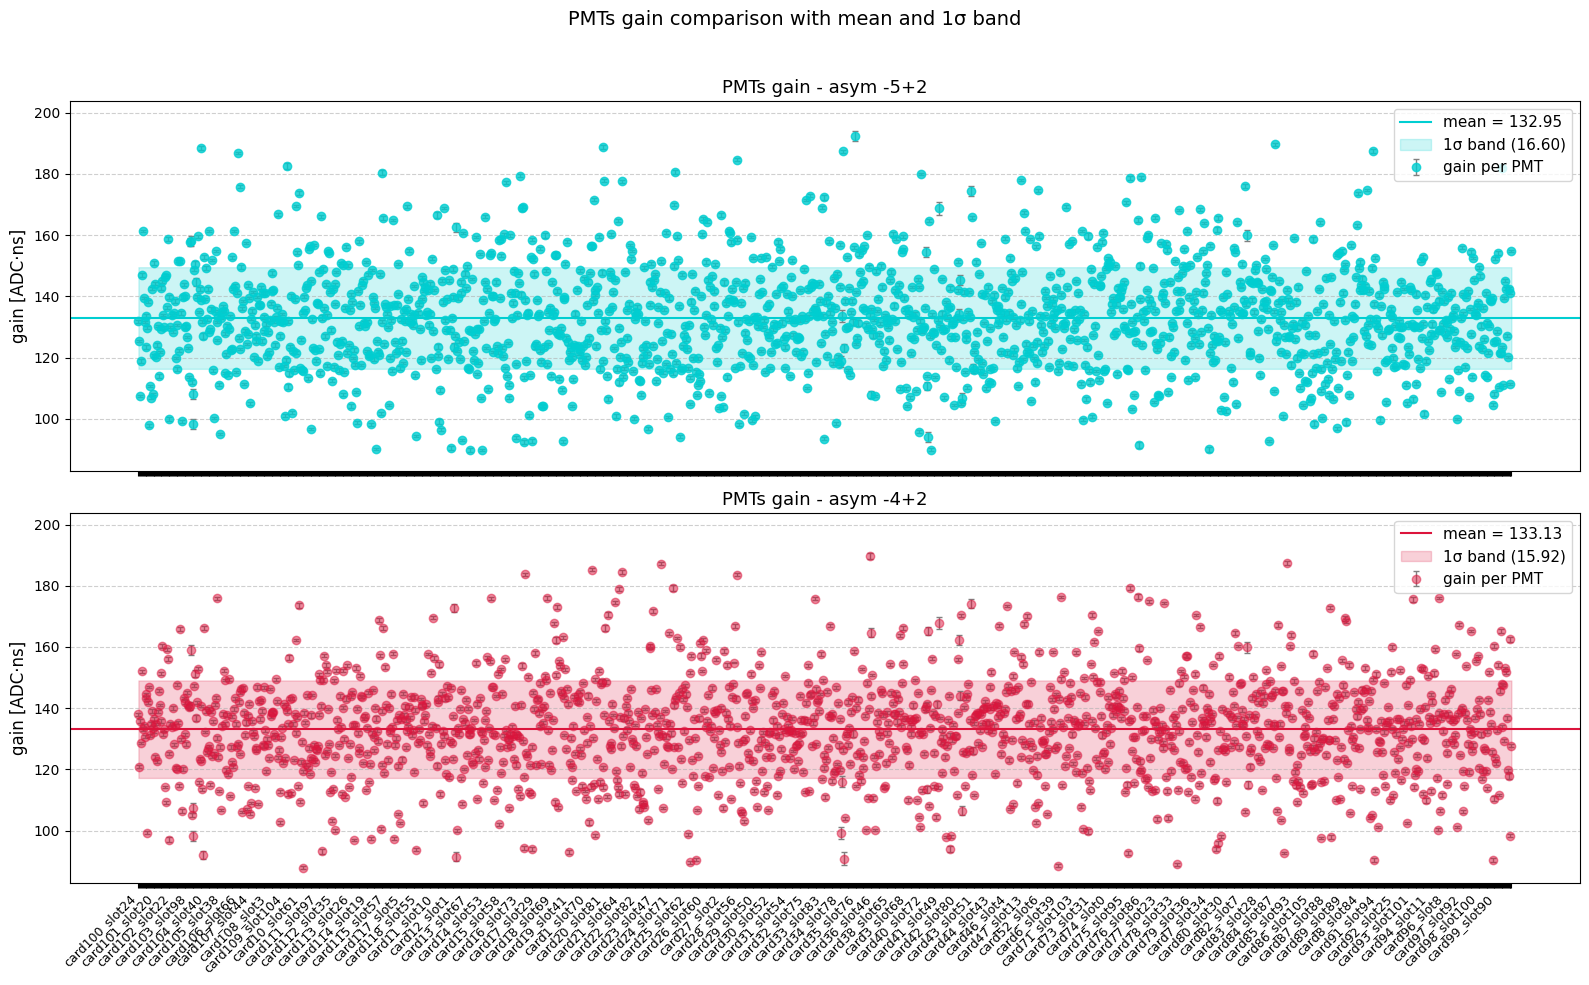

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- Archivos de resultados con path completo ---
files = {
    "asym -5+2": "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced_asym.npz",
    "asym -4+2": "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced_[-4,+2].npz"
}

# --- Cargar datos ---
results = {}
for label, file in files.items():
    data = np.load(file)["results"]
    results[label] = data

# --- Crear labels y orden por card+slot+channel ---
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in results["asym -5+2"]:  # usar uno como referencia para el eje x
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

# --- Calcular los límites comunes de ejes ---
all_gains = []
all_errors = []
for data in results.values():
    gains = data["gain"].astype(float)
    pedestal_sigma = data["pedestal_sigma"].astype(float)
    spe_sigma = data["spe_sigma"].astype(float)
    N_pedestal = data["N_pedestal"].astype(float)
    N_spe = data["N_spe"].astype(float)

    N_pedestal[N_pedestal == 0] = np.nan
    N_spe[N_spe == 0] = np.nan

    gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                          (spe_sigma/np.sqrt(N_spe))**2)

    mask = np.isfinite(gains) & np.isfinite(gain_errors)
    all_gains.append(gains[mask])
    all_errors.append(gain_errors[mask])

all_gains = np.concatenate(all_gains)
all_errors = np.concatenate(all_errors)

y_min = np.min(all_gains - all_errors) * 0.95
y_max = np.max(all_gains + all_errors) * 1.05

# --- Crear figura con subplots ---
fig, axes = plt.subplots(2, 1, figsize=(16,10), sharex=True, sharey=True)

colors = {"asym -5+2":"darkturquoise", "asym -4+2":"crimson"}

for ax, (label, data) in zip(axes, results.items()):
    gains = data["gain"].astype(float)
    pedestal_sigma = data["pedestal_sigma"].astype(float)
    spe_sigma = data["spe_sigma"].astype(float)
    N_pedestal = data["N_pedestal"].astype(float)
    N_spe = data["N_spe"].astype(float)

    N_pedestal[N_pedestal == 0] = np.nan
    N_spe[N_spe == 0] = np.nan

    gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                          (spe_sigma/np.sqrt(N_spe))**2)

    # --- scatter con error bars ---
    eb = ax.errorbar(
        x, gains, yerr=gain_errors,
        fmt='o', color=colors[label], ecolor='gray',
        elinewidth=1, capsize=2,
        alpha=1.0,  # alpha de las barras de error siempre 1
        label="gain per PMT"
    )

    # --- alpha más flojo solo para los puntos ---
    if label == "asym -4+2":
        for line in eb.lines[0:1]:  # solo los markers
            line.set_alpha(0.5)
    if label == "asym -5+2":
        for line in eb.lines[0:1]:
            line.set_alpha(0.8)

    # --- Calcular mean y std ---
    mean_gain = np.nanmean(gains)
    std_gain = np.nanstd(gains)

    # --- Banda de 1σ ---
    ax.axhline(mean_gain, color=colors[label], lw=1.5,
               label=f"mean = {mean_gain:.2f}")
    ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain,
                    color=colors[label], alpha=0.2, 
                    label=f"1σ band ({std_gain:.2f})")

    # --- Formatting ---
    ax.set_ylim(y_min, y_max)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(fontsize=11, loc="upper right")
    ax.set_ylabel("gain [ADC·ns]", fontsize=12)
    ax.set_title(f"PMTs gain - {label}", fontsize=13)

axes[-1].set_xticks(ticks=x)
axes[-1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

fig.suptitle("PMTs gain comparison with mean and 1σ band", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

Guardado en relative_gain_errors_asym_-5+2.npz


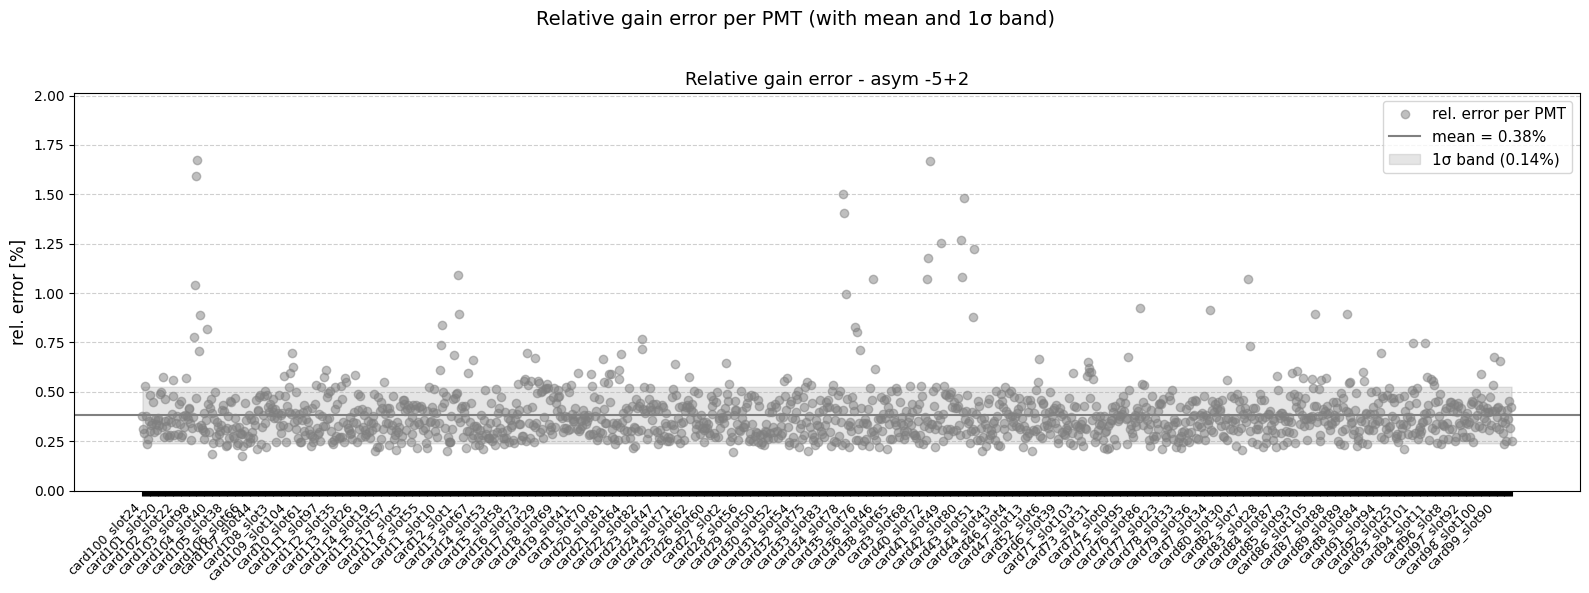

In [3]:
# --- Seleccionar solo el dataset de interés ---
label = "asym -5+2"
#label = "asym -4+2"
data = results[label]   # np.ndarray con los campos del fit

gains = data["gain"].astype(float)
pedestal_sigma = data["pedestal_sigma"].astype(float)
spe_sigma = data["spe_sigma"].astype(float)
N_pedestal = data["N_pedestal"].astype(float)
N_spe = data["N_spe"].astype(float)

# evitar divisiones por 0
N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                      (spe_sigma/np.sqrt(N_spe))**2)

# --- error relativo en % ---
rel_error = (gain_errors / gains) * 100.0

# --- Guardar solo este resultado ---

np.savez("relative_gain_errors_asym_-5+2.npz", rel_error=rel_error, x_labels=x_labels)
print("Guardado en relative_gain_errors_asym_-5+2.npz")

#np.savez("relative_gain_errors_asym_-4+2.npz", rel_error=rel_error, x_labels=x_labels)
#print("Guardado en relative_gain_errors_asym_-4+2.npz")


# --- Plot ---
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(x, rel_error, 'o', color="gray", alpha=0.5, label="rel. error per PMT")

# estadísticas
mean_rel = np.nanmean(rel_error)
std_rel  = np.nanstd(rel_error)

ax.axhline(mean_rel, color="gray", lw=1.5,
           label=f"mean = {mean_rel:.2f}%")
ax.fill_between(x, mean_rel-std_rel, mean_rel+std_rel,
                color="gray", alpha=0.2, 
                label=f"1σ band ({std_rel:.2f}%)")

y_min = 0
y_max = np.nanmax(rel_error[np.isfinite(rel_error)]) * 1.2
ax.set_ylim(y_min, y_max)

ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(fontsize=11, loc="upper right")
ax.set_ylabel("rel. error [%]", fontsize=12)
ax.set_title(f"Relative gain error - {label}", fontsize=13)

ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

fig.suptitle("Relative gain error per PMT (with mean and 1σ band)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [4]:
# --- Cargar archivo npz ---
data = np.load("relative_gain_errors_asym_-5+2.npz", allow_pickle=True)
#data = np.load("relative_gain_errors_asym_-4+2.npz", allow_pickle=True)
rel_error = data["rel_error"]
x_labels  = data["x_labels"]

# --- Mostrar los primeros 20 valores ---
print("Primeros 30 errores relativos (%):\n")
for i in range(min(30, len(rel_error))):
    print(f"{i:3d}  {x_labels[i]:20s}  {rel_error[i]:.2f} %")

Primeros 30 errores relativos (%):

  0  card100_slot24        0.38 %
  1                        0.31 %
  2                        0.29 %
  3                        0.53 %
  4                        0.38 %
  5                        0.23 %
  6                        0.26 %
  7                        0.35 %
  8                        0.30 %
  9                        0.49 %
 10                        0.33 %
 11                        0.34 %
 12                        0.45 %
 13                        0.30 %
 14                        0.36 %
 15                        0.33 %
 16                        0.31 %
 17                        0.37 %
 18                        0.36 %
 19  card101_slot20        0.33 %
 20                        0.49 %
 21                        0.50 %
 22                        0.32 %
 23                        0.58 %
 24                        0.27 %
 25                        0.46 %
 26                        0.35 %
 27                        0.33 %
 28         

In [5]:
import numpy as np

# --- Cargar archivo npz ---
data = np.load("relative_gain_errors_asym_-5+2.npz", allow_pickle=True)
#data = np.load("relative_gain_errors_asym_-4+2.npz", allow_pickle=True)
rel_error = data["rel_error"]
x_labels  = data["x_labels"]

# Extraer card, slot, channel de pmt_labels
cards = []
slots = []
channels = []

for pmt in pmt_labels:  # formato: "card_slot_channel"
    c, s, ch = pmt.split("_")
    cards.append(int(c))
    slots.append(int(s))
    channels.append(int(ch))

cards = np.array(cards)
slots = np.array(slots)
channels = np.array(channels)

# --- Filtrar nan ---
valid_idx = np.isfinite(rel_error)

cards = cards[valid_idx]
slots = slots[valid_idx]
channels = channels[valid_idx]
rel_error = rel_error[valid_idx]

# --- Ordenar por error relativo descendente ---
worst_idx = np.argsort(rel_error)[::-1]

print("Top 5 PMTs con mayor error relativo en el gain (ignorando nan):\n")
print(f"{'Rank':<5}{'Card':<8}{'Slot':<8}{'Chan':<8}{'Error (%)':<10}")
print("-"*45)
for rank, idx in enumerate(worst_idx[:5], start=1):
    print(f"{rank:<5}{cards[idx]:<8}{slots[idx]:<8}{channels[idx]:<8}{rel_error[idx]:.2f}")

Top 5 PMTs con mayor error relativo en el gain (ignorando nan):

Rank Card    Slot    Chan    Error (%) 
---------------------------------------------
1    103     98      14      1.68
2    40      72      13      1.67
3    103     98      13      1.59
4    34      78      10      1.50
5    42      80      13      1.48


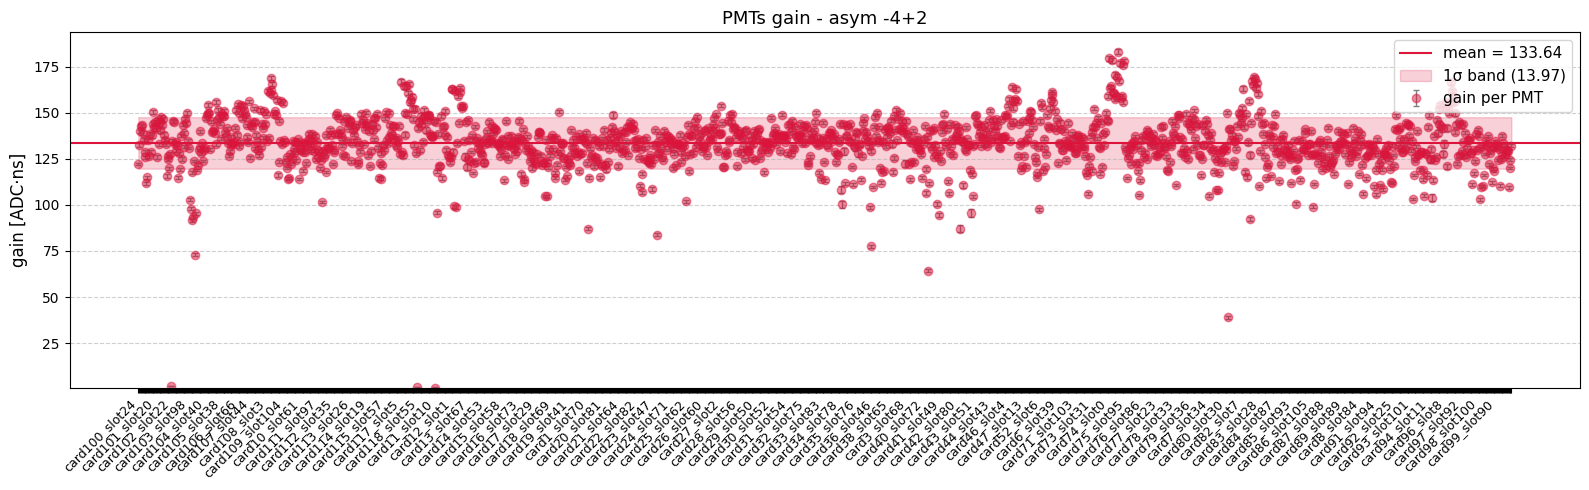

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Archivo de resultados morado ---
file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss.npz"
data = np.load(file)["results"]

# --- Crear labels y orden por card+slot+channel ---
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in data:
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

# --- Calcular gain y errores ---
gains = data["gain"].astype(float)
pedestal_sigma = data["pedestal_sigma"].astype(float)
spe_sigma = data["spe_sigma"].astype(float)
N_pedestal = data["N_pedestal"].astype(float)
N_spe = data["N_spe"].astype(float)

N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                      (spe_sigma/np.sqrt(N_spe))**2)

# --- Limites de eje y ---
mask = np.isfinite(gains) & np.isfinite(gain_errors)
y_min = np.min(gains[mask] - gain_errors[mask]) * 0.95
y_max = np.max(gains[mask] + gain_errors[mask]) * 1.05

# --- Crear figura ---
fig, ax = plt.subplots(figsize=(16,5))

color = "crimson"

# --- Scatter con error bars ---
eb = ax.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color=color, ecolor='gray',
    elinewidth=1, capsize=2,
    alpha=1.0,  # barras de error opacas
    label="gain per PMT"
)

# --- Puntos más flojos ---
for line in eb.lines[0:1]:
    line.set_alpha(0.5)

# --- Mean y 1σ ---
mean_gain = np.nanmean(gains)
std_gain = np.nanstd(gains)

ax.axhline(mean_gain, color=color, lw=1.5, label=f"mean = {mean_gain:.2f}")
ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain, color=color, alpha=0.2,
                label=f"1σ band ({std_gain:.2f})")

# --- Formato ---
ax.set_ylim(y_min, y_max)
ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylabel("gain [ADC·ns]", fontsize=12)
ax.set_title("PMTs gain - asym -4+2", fontsize=13)
ax.legend(fontsize=11, loc="upper right")

plt.tight_layout()
plt.show()

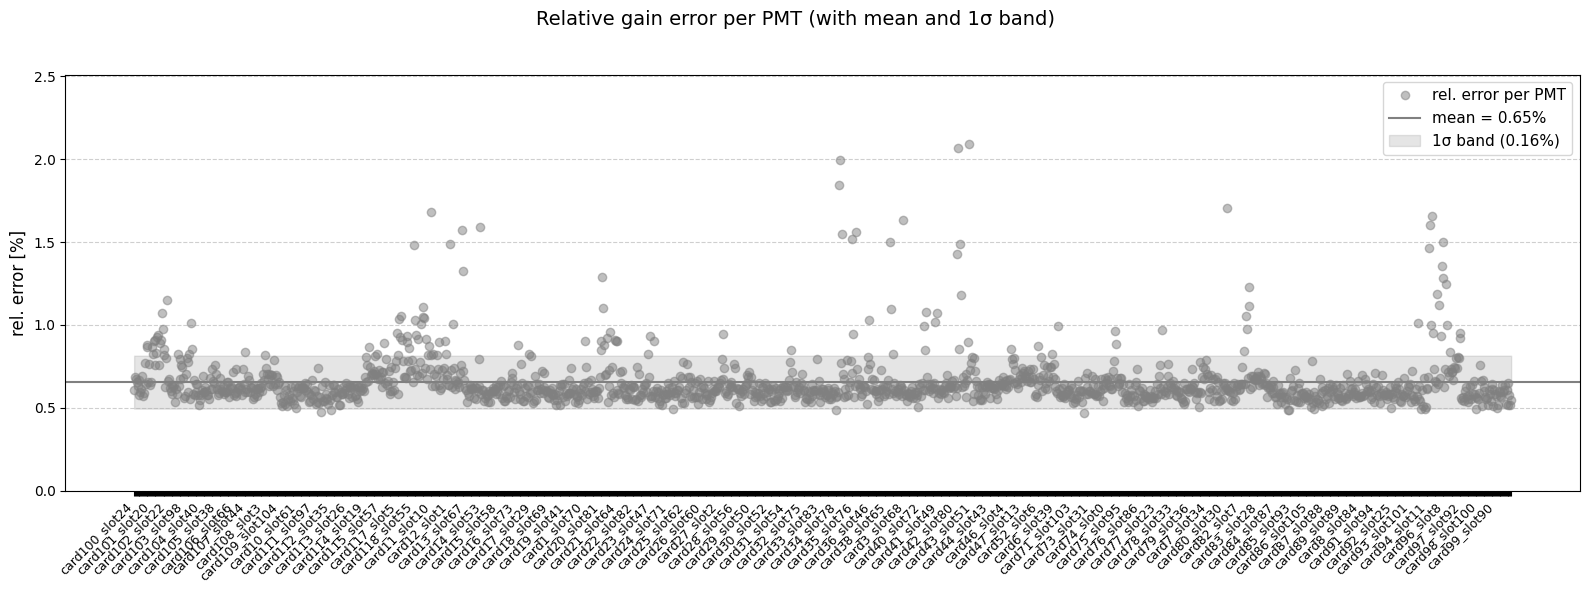

In [33]:
import numpy as np
import matplotlib.pyplot as plt

file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss.npz"
data = np.load(file)["results"]

# --- Build x axis and labels (same as in gain plot) ---
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in data:
    key = (int(r["card_id"]), int(r["slot_id"]))
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

# --- Extract fit parameters ---
gains = data["gain"].astype(float)
pedestal_sigma = data["pedestal_sigma"].astype(float)
spe_sigma = data["spe_sigma"].astype(float)
N_pedestal = data["N_pedestal"].astype(float)
N_spe = data["N_spe"].astype(float)

# evitar divisiones por 0
N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 +
                      (spe_sigma/np.sqrt(N_spe))**2)

# --- error relativo en % ---
rel_error = (gain_errors / gains) * 100.0

# --- Save result ---
#np.savez("relative_gain_errors_asym_-5+2.npz", rel_error=rel_error, x_labels=x_labels)
#print("Guardado en relative_gain_errors_asym_-5+2.npz")

# --- Plot ---
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(x, rel_error, 'o', color="gray", alpha=0.5, label="rel. error per PMT")

# estadísticas
mean_rel = np.nanmean(rel_error)
std_rel  = np.nanstd(rel_error)

ax.axhline(mean_rel, color="gray", lw=1.5,
           label=f"mean = {mean_rel:.2f}%")
ax.fill_between(x, mean_rel-std_rel, mean_rel+std_rel,
                color="gray", alpha=0.2,
                label=f"1σ band ({std_rel:.2f}%)")

y_min = 0
y_max = np.nanmax(rel_error[np.isfinite(rel_error)]) * 1.2
ax.set_ylim(y_min, y_max)

ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(fontsize=11, loc="upper right")
ax.set_ylabel("rel. error [%]", fontsize=12)

ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

fig.suptitle("Relative gain error per PMT (with mean and 1σ band)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

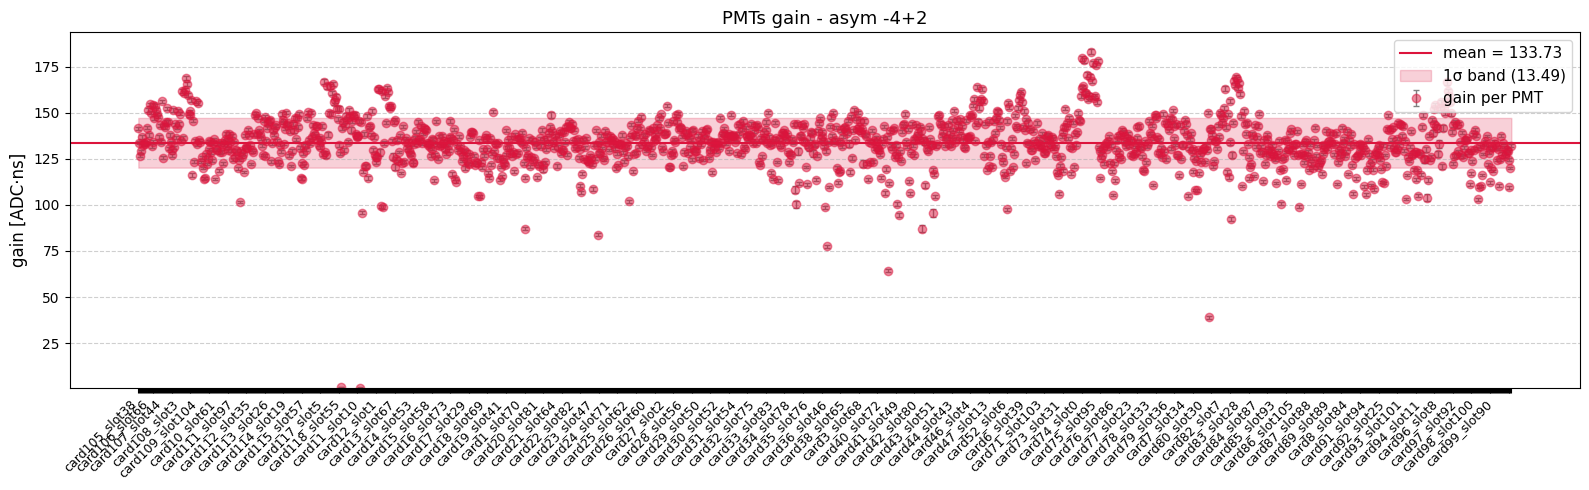

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- Lista de archivos npz (chunks) ---
npz_dir = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/"
n_chunks = 15
npz_files = [f"{npz_dir}pmt_charge_fit_results_doubleGauss_{i}.npz" for i in range(1, n_chunks+1)]

# --- Cargar todos los resultados ---
all_results_list = []

for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

# Concatenar todos los chunks en un solo array estructurado
data = np.concatenate(all_results_list)

# --- Crear labels y orden por card+slot+channel ---
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in data:
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

# --- Calcular gain y errores ---
gains = data["gain"].astype(float)
pedestal_sigma = data["pedestal_sigma"].astype(float)
spe_sigma = data["spe_sigma"].astype(float)
N_pedestal = data["N_pedestal"].astype(float)
N_spe = data["N_spe"].astype(float)

N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                      (spe_sigma/np.sqrt(N_spe))**2)

# --- Limites de eje y ---
mask = np.isfinite(gains) & np.isfinite(gain_errors)
y_min = np.min(gains[mask] - gain_errors[mask]) * 0.95
y_max = np.max(gains[mask] + gain_errors[mask]) * 1.05

# --- Crear figura ---
fig, ax = plt.subplots(figsize=(16,5))

color = "crimson"

# --- Scatter con error bars ---
eb = ax.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color=color, ecolor='gray',
    elinewidth=1, capsize=2,
    alpha=1.0,
    label="gain per PMT"
)

# --- Puntos más flojos ---
for line in eb.lines[0:1]:
    line.set_alpha(0.5)

# --- Mean y 1σ ---
mean_gain = np.nanmean(gains)
std_gain = np.nanstd(gains)

ax.axhline(mean_gain, color=color, lw=1.5, label=f"mean = {mean_gain:.2f}")
ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain, color=color, alpha=0.2,
                label=f"1σ band ({std_gain:.2f})")

# --- Formato ---
ax.set_ylim(y_min, y_max)
ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylabel("gain [ADC·ns]", fontsize=12)
ax.set_title("PMTs gain - asym -4+2", fontsize=13)
ax.legend(fontsize=11, loc="upper right")

plt.tight_layout()
plt.show()

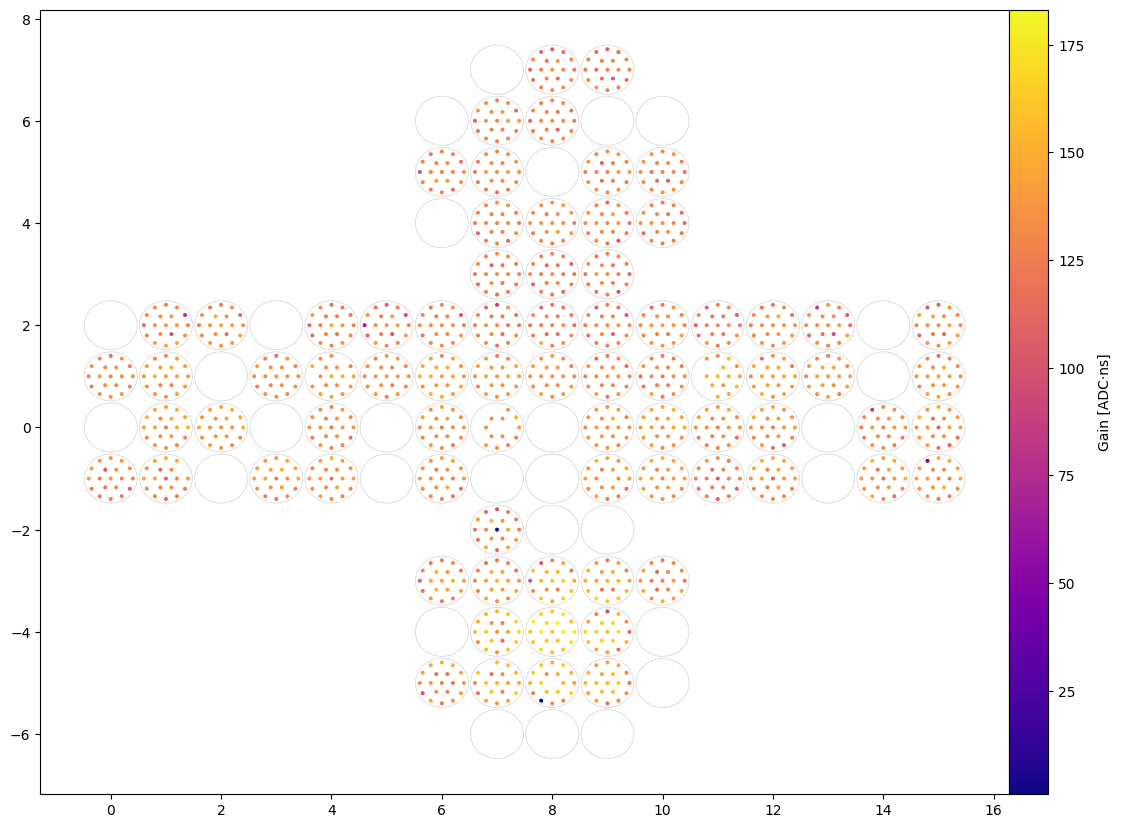

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys

# Path al repo
wcte_event_display_path = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

# --- Cargar todos los chunks NPZ si quieres ---
npz_dir = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/"
n_chunks = 15
npz_files = [f"{npz_dir}pmt_charge_fit_results_doubleGauss_{i}.npz" for i in range(1, n_chunks+1)]

all_results_list = []
for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

# Concatenar todos los chunks
results = np.concatenate(all_results_list)

# --- Inicializamos EventDisplay ---
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

# --- Creamos array de gains por canal ---
gain_per_channel = np.full(ed.nChannels, np.nan)  # inicializamos con NaN

# --- Llenamos gain_per_channel usando índice directo ---
for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])  # channel_id en 0..18
    gain = float(entry['gain'])
    
    # mPMT_id se corresponde con 'slot' según geometría
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

# --- Hacemos el plot ---
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,   # colormap
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None  # estilo normal, fondo blanco
)

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

# --- Calcular estadísticos resumidos ---
summary = []
for label, data in results.items():
    gains = data["gain"].astype(float)
    pedestal_sigma = data["pedestal_sigma"].astype(float)
    spe_sigma = data["spe_sigma"].astype(float)
    N_pedestal = data["N_pedestal"].astype(float)
    N_spe = data["N_spe"].astype(float)

    N_pedestal[N_pedestal == 0] = np.nan
    N_spe[N_spe == 0] = np.nan

    gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                          (spe_sigma/np.sqrt(N_spe))**2)

    mean_gain = np.nanmean(gains)
    std_gain = np.nanstd(gains)
    mean_rel_err = np.nanmean(gain_errors / gains)

    summary.append({
        "Dataset": label,
        "Mean Gain [ADC·ns]": f"{mean_gain:.2f}",
        "Std Dev [ADC·ns]": f"{std_gain:.2f}",
        "Mean Rel. Error": f"{mean_rel_err:.3f}"
    })

df_summary = pd.DataFrame(summary)
df_summary

,Dataset,Mean Gain [ADC·ns],Std Dev [ADC·ns],Mean Rel. Error
0,asym -5+2,132.95,16.60,0.004
1,asym -4+2,133.13,15.92,0.004


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

npz_file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced_[-4,+2].npz"   #pmt_...s_enhanced.npz  integration_ window=16 bins
                                                                                                         #pmt_...s_enhanced_12.npz  integration_ window=12 bins
                                                                                                         #pmt_...s_enhanced_asym.npz  integration_ window=[-5,+2]]
data = np.load(npz_file)
results = data["results"]   #leemos los resultados saved en el npz


df = pd.DataFrame(results)

In [9]:
# filtrar por card_id
#df[df['card_id'] == 29]

#mPMT específico 
#df[(df['card_id'] == 29) & (df['slot_id'] == 50)]

#filtrar por gain mayor de 100
#df[df['gain'] > 100]

#gain ascendente
#df.sort_values(by='gain', ascending=True).head(10)


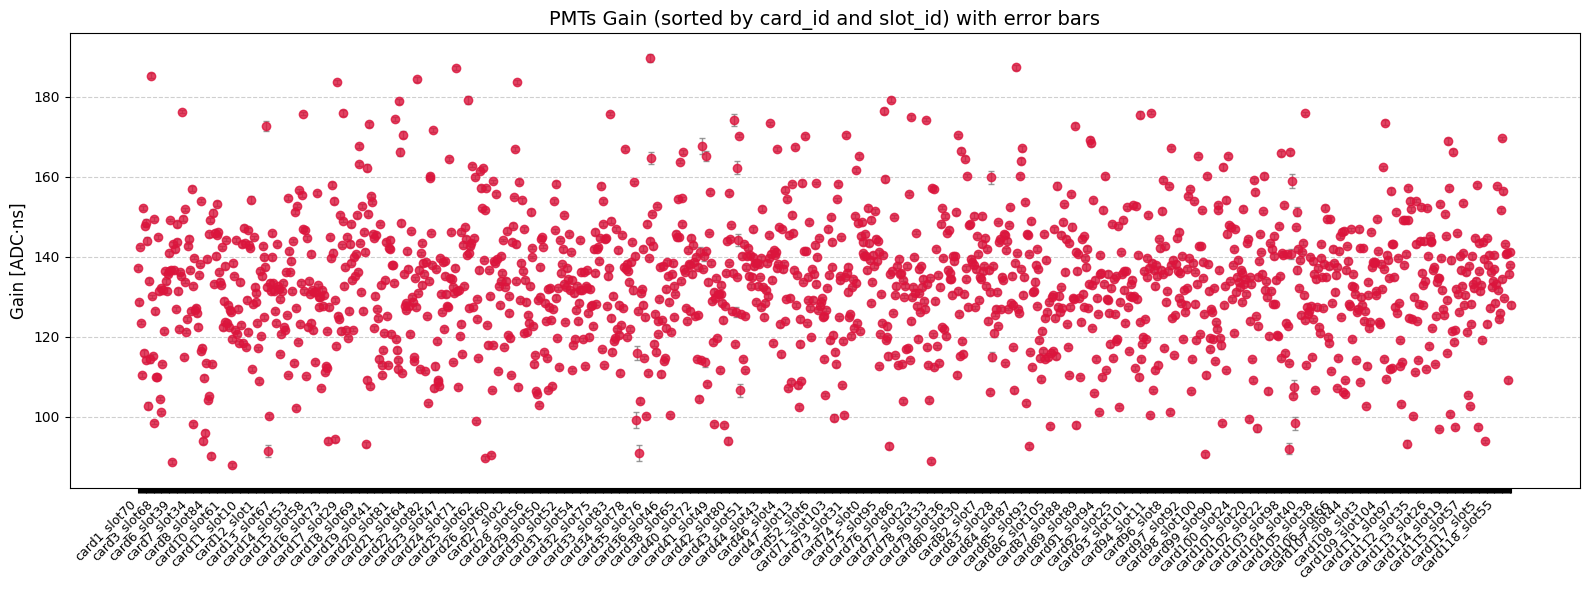

In [10]:
df_sorted = df.sort_values(by=['card_id', 'slot_id', 'channel_id']).reset_index(drop=True)

# Index para eje x
x = np.arange(len(df_sorted))

# Ganancia y barras de error
gains = df_sorted['gain'].values
pedestal_sigma = df_sorted['pedestal_sigma'].values
spe_sigma = df_sorted['spe_sigma'].values
N_pedestal = df_sorted['N_pedestal'].values
N_spe = df_sorted['N_spe'].values

# Error de gain ya calculado (propagación de errores)
gain_errors = np.sqrt( (pedestal_sigma/np.sqrt(N_pedestal))**2 + (spe_sigma/np.sqrt(N_spe))**2 )

# Etiquetas únicas por mPMT (card+slot)
seen_mpmt = set()
xtick_labels = []
for c, s, ch in zip(df_sorted['card_id'], df_sorted['slot_id'], df_sorted['channel_id']):
    key = (c, s)
    if key not in seen_mpmt:
        xtick_labels.append(f"card{c}_slot{s}")
        seen_mpmt.add(key)
    else:
        xtick_labels.append("")

# --- Plot con barras de error ---
plt.figure(figsize=(16,6))
plt.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color='crimson', ecolor='gray',
    elinewidth=1, capsize=2, alpha=0.8
)

plt.xticks(ticks=x, labels=xtick_labels, rotation=45, ha='right', fontsize=9)
plt.ylabel("Gain [ADC·ns]", fontsize=12)
plt.title("PMTs Gain (sorted by card_id and slot_id) with error bars", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:

gains = results['gain']

mean_gain = np.nanmean(gains)
max_gain  = np.nanmax(gains)
min_gain  = np.nanmin(gains)

print(f"Gain mean: {mean_gain:.2f} ADC·ns")
print(f"Gain max: {max_gain:.2f} ADC·ns")
print(f"Gain min: {min_gain:.2f} ADC·ns")

Gain mean: 133.13 ADC·ns
Gain max: 189.75 ADC·ns
Gain min: 87.92 ADC·ns


In [24]:
npz_file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss.npz"
data = np.load(npz_file)
results = data["results"]

# Convertir a DataFrame
df = pd.DataFrame(results)

# Añadir etiqueta única de PMT
df["pmt_label"] = df.apply(lambda r: f"card{int(r['card_id'])}_slot{int(r['slot_id'])}_ch{int(r['channel_id'])}", axis=1)

# --- Filtrar solo PMTs con gain válido ---
df_clean = df.dropna(subset=["gain"]).reset_index(drop=True)

# --- Estadísticas globales ---
mean_gain = df_clean["gain"].mean()
std_gain = df_clean["gain"].std()
print(f"Mean gain = {mean_gain:.2f}, Std = {std_gain:.2f}")

# --- Worst 10 (5 más bajos + 5 más altos) ---
df_sorted = df_clean.sort_values(by="gain", ascending=True)
worst_5_low = df_sorted.head(5)[["gain", "pmt_label"]]
worst_5_high = df_sorted.tail(5)[["gain", "pmt_label"]]
worst_10 = pd.concat([worst_5_low, worst_5_high])

# --- Best 10 (más cercanos a la media) ---
df_clean["dist_from_mean"] = np.abs(df_clean["gain"] - mean_gain)
best_10 = df_clean.sort_values(by="dist_from_mean").head(10)[["gain", "pmt_label"]]

# --- Mostrar tablas ---
print("\n=== 10 Worst PMTs (extreme gains) ===")
print(worst_10.to_string(index=False))

print("\n=== 10 Best PMTs (gains near mean) ===")
print(best_10.to_string(index=False))


Mean gain = 133.64, Std = 13.97

=== 10 Worst PMTs (extreme gains) ===
      gain          pmt_label
  0.897823  card11_slot10_ch0
  1.151647  card117_slot5_ch9
  1.534709 card102_slot22_ch0
 38.992488 card80_slot30_ch11
 64.329364 card40_slot72_ch13
176.784342   card74_slot0_ch4
177.973424   card74_slot0_ch9
178.439589  card74_slot0_ch12
179.530937   card74_slot0_ch1
183.197415   card74_slot0_ch2

=== 10 Best PMTs (gains near mean) ===
      gain           pmt_label
133.638479   card31_slot54_ch9
133.642205   card89_slot89_ch3
133.626473  card24_slot71_ch13
133.649206   card18_slot69_ch3
133.624753  card77_slot23_ch12
133.617174  card14_slot53_ch11
133.614937  card99_slot90_ch17
133.667932 card115_slot57_ch11
133.605874   card3_slot68_ch14
133.589586   card15_slot58_ch2


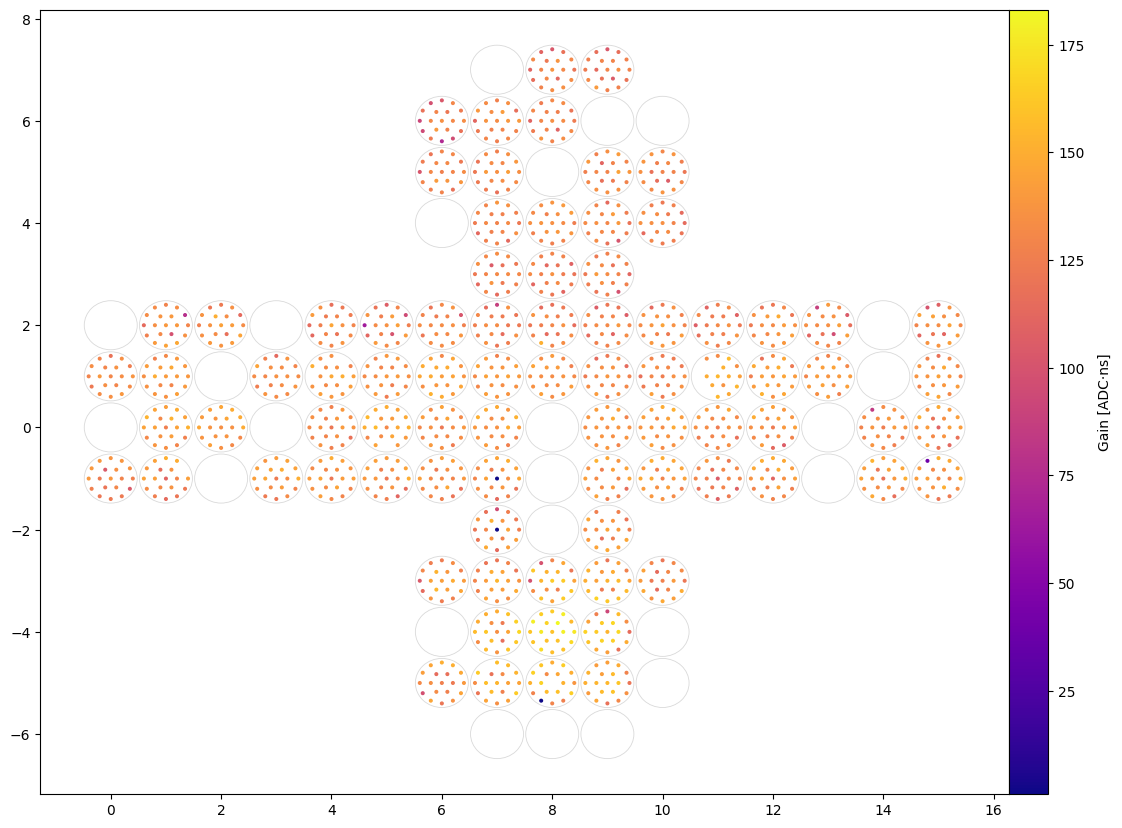

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys


# Path al repo
wcte_event_display_path = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

# Inicializamos EventDisplay
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

# Creamos el array de gains por canal
gain_per_channel = np.full(ed.nChannels, np.nan)  # inicializamos con NaN

# Llenamos gain_per_channel usando índice directo: idx = 19*mPMT_id + channel_id
for entry in results:
    card = entry['card_id']
    slot = entry['slot_id']
    ch   = entry['channel_id']  # channel_id en 0..18
    gain = entry['gain']
    
    # mPMT_id se corresponde con 'slot' o 'card+slot'? Depende de tu mPMT_2D_projection
    # Suponemos aquí que slot_id = índice de mPMT en la geometría
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

# Hacemos el plot
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,   # colormap que quieras
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None  # <- estilo normal, fondo blanco
)

plt.tight_layout()
plt.show()

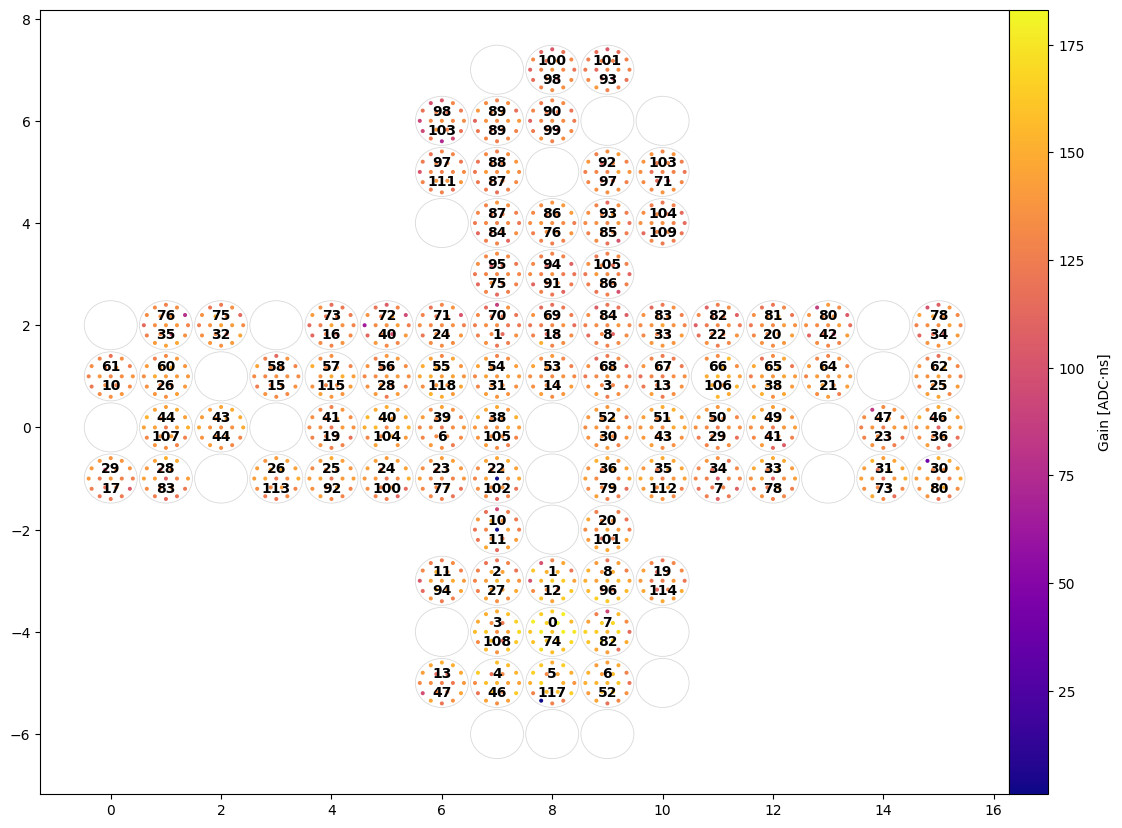

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys


# --- Archivos de resultados con path completo ---
files = {
    "asym -5+2": "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced_asym.npz",
    "asym -4+2": "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss.npz"
}

# --- Cargar datos ---
results = {}
for label, file in files.items():
    data = np.load(file)["results"]
    results[label] = data


# Path al repo
wcte_event_display_path = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

# -------------------------------
# Inicializamos EventDisplay
# -------------------------------
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

# -------------------------------
# Seleccionamos los resultados de la ventana asimétrica [-4,+2]
# -------------------------------
data_array = results["asym -4+2"]  # numpy structured array

# -------------------------------
# Creamos array de gains por canal
# -------------------------------
gain_per_channel = np.full(ed.nChannels, np.nan)  # inicializamos con NaN

# -------------------------------
# Rellenamos gain_per_channel
# -------------------------------
for i in range(len(data_array)):
    card  = data_array['card_id'][i]
    slot  = data_array['slot_id'][i]
    ch    = data_array['channel_id'][i]
    gain  = data_array['gain'][i]

    # Suponemos que slot_id = índice del mPMT en la geometría
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

# -------------------------------
# Dibujamos event display
# -------------------------------
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None
)

# -------------------------------
# Añadimos etiquetas: slot_id arriba y card_id abajo dentro del círculo del mPMT
# -------------------------------
for mPMT_idx, (x, y) in enumerate(ed.mPMT_2D_projection[:,1:3]):
    # Filtramos todos los canales de este mPMT
    entries = data_array[data_array['slot_id'] == mPMT_idx]
    if len(entries) == 0:
        continue
    slot_id = entries['slot_id'][0]
    card_id = entries['card_id'][0]

    plt.text(x, y + 0.05, str(slot_id), color='k', fontsize=10, fontweight='bold',
             ha='center', va='bottom')
    plt.text(x, y - 0.05, str(card_id), color='k', fontsize=10, fontweight='bold',
             ha='center', va='top')

plt.tight_layout()
plt.show()


In [29]:
# Extraemos todos los card_id y slot_id
card_ids = np.array([entry['card_id'] for entry in results])
slot_ids = np.array([entry['slot_id'] for entry in results])

# Mostramos mínimo y máximo
print(f"Card ID: min = {card_ids.min()}, max = {card_ids.max()}")
print(f"Slot ID: min = {slot_ids.min()}, max = {slot_ids.max()}")

TypeError: string indices must be integers

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys

# Path al repo
wcte_event_display_path = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

# --- Inicializar EventDisplay ---
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

# --- Crear array de gains por canal ---
gain_per_channel = np.full(ed.nChannels, np.nan)  # inicializamos con NaN

# --- Mapping robusto card+slot -> mPMT index ---
# Creamos un diccionario que nos diga qué índice de mPMT corresponde a cada card+slot
mPMT_index_map = {}
for i, mPMT_id in enumerate(ed.mPMT_2D_projection[:,0]):
    # ed.mPMT_2D_projection[:,0] contiene IDs únicos de cada mPMT
    # Ajusta si tu ID real viene de card+slot concatenado
    mPMT_index_map[mPMT_id] = i

# --- Llenamos gain_per_channel ---
for entry in results:
    card = entry['card_id']
    slot = entry['slot_id']
    ch   = entry['channel_id']  # channel_id en 0..18
    gain = entry['gain']
    
    # Aquí mPMT_id depende de cómo definiste la geometría
    # Si tus mPMT_id son iguales a slot_id, usamos slot como mPMT_id
    # Si no, hay que mapear card+slot a mPMT_id según tu mPMT_2D_projection
    mPMT_id = slot  # <-- AJUSTA si tu mPMT_id no coincide con slot
    if mPMT_id in mPMT_index_map:
        idx = 19 * mPMT_index_map[mPMT_id] + ch
        if idx < ed.nChannels:
            gain_per_channel[idx] = gain
    else:
        print(f"Warning: mPMT_id {mPMT_id} not found in geometry!")

# --- Plot EventDisplay ---
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.magma,
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style="dark_background"
)
plt.tight_layout()
plt.show()

TypeError: string indices must be integers